### Analyzing sequential data using recurrent neural networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import neurolab as nl

In [2]:
#A function to generate waveforms
def get_data(num_points):
    #Create sine waveforms
    wave_1 = 0.5 * np.sin(np.arange(0, num_points))
    wave_2 = 3.6 * np.sin(np.arange(0, num_points))
    wave_3 = 1.1 * np.sin(np.arange(0, num_points))
    wave_4 = 4.7 * np.sin(np.arange(0, num_points))
    
    #Create varying amplitudes
    amp_1 = np.ones(num_points)
    amp_2 = 2.1 + np.zeros(num_points)
    amp_3 = 3.2 * np.ones(num_points)
    amp_4 = 0.8 + np.zeros(num_points)
    
    #Create the overall waveform
    wave = np.array([wave_1, wave_2, wave_3, wave_4]).reshape(num_points * 4, 1)
    amp = np.array([amp_1, amp_2, amp_3, amp_4]).reshape(num_points * 4, 1)
    
    return wave, amp

In [3]:
#Visualize the output
def visualize_output(nn, num_points_test):
    wave, amp = get_data(num_points_test)
    output = nn.sim(wave)
    
    plt.plot(amp.reshape(num_points_test * 4))
    plt.plot(output.reshape(num_points_test * 4))

In [4]:
#Create sample data
num_points = 40
wave, amp = get_data(num_points)

In [5]:
#Create a recurrent neural network with 2 layers
nn = nl.net.newelm([[-2, 2]], [10, 1], [nl.trans.TanSig(), nl.trans.PureLin()])

#Set the init functions for each layer
nn.layers[0].initf = nl.init.InitRand([-0.1, 0.1], 'wb')
nn.layers[1].initf = nl.init.InitRand([-0.1, 0.1], 'wb')
nn.init()

In [7]:
#Train the recurrent neural network
error_progress = nn.train(wave, amp, epochs = 1200, show = 100, goal = 0.01)

Epoch: 100; Error: 0.8620630389412354;
Epoch: 200; Error: 0.7029025613164969;
Epoch: 300; Error: 0.7599523994446907;
Epoch: 400; Error: 0.41048865029687864;
Epoch: 500; Error: 0.7389553868878537;
Epoch: 600; Error: 0.1225463084458667;
Epoch: 700; Error: 0.11741010436138928;
Epoch: 800; Error: 0.12255985776815874;
Epoch: 900; Error: 0.12638802313941402;
Epoch: 1000; Error: 0.11354886955966777;
Epoch: 1100; Error: 0.11579245229799442;
Epoch: 1200; Error: 0.11097256489006964;
The maximum number of train epochs is reached


In [8]:
#Run the training data through the network
output = nn.sim(wave)

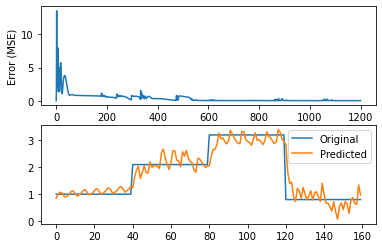

In [12]:
#Plot the results
plt.figure()

plt.subplot(211)
plt.plot(error_progress)
plt.xlabel('Number of epochs')
plt.ylabel('Error (MSE)')

plt.subplot(212)
plt.plot(amp.reshape(num_points * 4))
plt.plot(output.reshape(num_points * 4))
plt.legend(['Original', 'Predicted']);

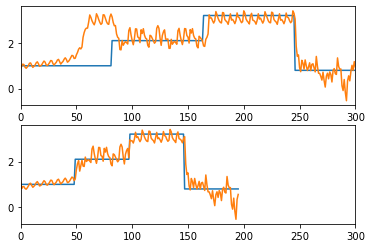

In [13]:
#Testing the network performance on unknown data
plt.figure()

plt.subplot(211)
visualize_output(nn, 82)
plt.xlim([0, 300])

plt.subplot(212)
visualize_output(nn, 49)
plt.xlim([0, 300]);

### Visualizing characters in an optical character recognition database

In [22]:
import cv2
import numpy as np

In [23]:
input_file = 'data/letter.data'

In [24]:
#Define the visualization parameters
img_resize_factor = 12
start = 6
end = -1
height, width = 16, 8

In [28]:
#Iterate through the images in the file until the user presses the 'Esc' key
with open(input_file, 'r') as f:
    for line in f.readlines():
        #Read the data and scale it up to 255
        data = np.array([255 * float(x) for x in line.split('\t')[start:end]])   #The file is tab-separated
        
        #Reshape the 1D image to 2D image
        img = np.reshape(data, (height, width))
        
        #Scale the image
        img_scaled = cv2.resize(img, None, fx = img_resize_factor, fy = img_resize_factor)
        
        #Display the image
        cv2.imshow('Image', img_scaled)
        
        #Check if the user pressed the 'Esc' key
        stop_key = cv2.waitKey(1)
        if stop_key == 27:
            break

### Building an optical character recognition engine

In [29]:
#Using the same data file above
num_datapoints = 50   #Define the number of datapoints to be loaded from the input file

#Define the training and testing parameters
num_train = int(0.9 * num_datapoints)
num_test = num_datapoints - num_train

In [30]:
orig_labels = 'omandig'   #String containing all the distinct characters
num_orig_labels = len(orig_labels)   #Number of distinct characters

#Define the dataset extraction parameters
start = 6
end = -1

In [31]:
#Creating the dataset
data = []
labels = []

with open(input_file, 'r') as f:
    for line in f.readlines():
        #Split the current line tabwise
        list_vals = line.split('\t')
        
        #If label not in our ground truth labels, skip
        if list_vals[1] not in orig_labels:
            continue
            
        #Extract the current label and append it to the main list
        label = np.zeros((num_orig_labels, 1))
        label[orig_labels.index(list_vals[1])] = 1
        labels.append(label)
        
        #Extract the character vector and append it to the main list
        cur_char = np.array([float(x) for x in list_vals[start:end]])
        data.append(cur_char)
        
        #Exit the loop once the required dataset has been created
        if len(data) >= num_datapoints:
            break

In [34]:
#Convert the data and labels to numpy arrays
data = np.asfarray(data)
labels = np.array(labels).reshape(num_datapoints, num_orig_labels)

In [37]:
#Extract the number of dimensions
num_dims = len(data[0])

In [38]:
#Create a feedforward neural network
nn = nl.net.newff([[0, 1] for _ in range(num_dims)], [128, 16, num_orig_labels])

#Set the training algorithm to gradient descent
nn.trainf = nl.train.train_gd

In [39]:
error_progress = nn.train(data[:num_train, :], labels[:num_train, :], epochs = 10000, show = 100, goal = 0.01)

Epoch: 100; Error: 44.944272379709744;
Epoch: 200; Error: 11.743196569004828;
Epoch: 300; Error: 4.60445095767462;
Epoch: 400; Error: 4.063885390483378;
Epoch: 500; Error: 2.6195483567621984;
Epoch: 600; Error: 2.0476288758192736;
Epoch: 700; Error: 1.6858590985660649;
Epoch: 800; Error: 1.4475451098647167;
Epoch: 900; Error: 1.3108921729165526;
Epoch: 1000; Error: 1.5710612525624656;
Epoch: 1100; Error: 1.296799555041566;
Epoch: 1200; Error: 1.0868721440932458;
Epoch: 1300; Error: 1.1656197612248165;
Epoch: 1400; Error: 1.114001172508464;
Epoch: 1500; Error: 1.0226847691956658;
Epoch: 1600; Error: 0.9622367217133604;
Epoch: 1700; Error: 1.3953068080133453;
Epoch: 1800; Error: 1.0193271477367207;
Epoch: 1900; Error: 0.9332304867971495;
Epoch: 2000; Error: 0.8653494483738249;
Epoch: 2100; Error: 0.8622891849751223;
Epoch: 2200; Error: 0.8627445150871804;
Epoch: 2300; Error: 0.8875516664898377;
Epoch: 2400; Error: 0.7869401023971809;
Epoch: 2500; Error: 0.7259494826101927;
Epoch: 2600; E

In [49]:
#Predict the output for test inputs
print('Testing on Unknown data\n')

predicted_test = nn.sim(data[num_train:, :])
for i in range(num_test):
    print('\nOriginal: ', orig_labels[np.argmax(labels[i])])
    print('Predicted:', orig_labels[np.argmax(predicted_test[i])])

Testing on Unknown data


Original:  o
Predicted: n

Original:  m
Predicted: n

Original:  m
Predicted: m

Original:  a
Predicted: o

Original:  n
Predicted: n
